## Import Data

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import os

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
### For editing purposes only ###
def import_data(file_path):
    drive.mount('/content/drive')

    try:
        data = pd.read_csv(file_path)
        print("File loaded successfully!")
        return data
    except:
        print(f"Failed to load file!")
        return None

In [5]:
# If you wish to run the code below locally for testing - please download the files and make the replacements listed below:
import pandas as pd
import os

def import_data(file_name):
    # Get the current working directory
    current_directory = os.getcwd()

    # Set the folder names - change "additional_path_to_data_folder" with your own path:
    data_folder = os.path.join(current_directory, 'additional_path_to_data_folder')  # Replace with the actual folder name

    # Construct the full file path
    file_path = os.path.join(data_folder, file_name)

    try:
        data = pd.read_csv(file_path)
        print("File loaded successfully!")
        return data
    except Exception as e:
        print(f"Failed to load file: {e}")
        return None

# Specify the CSV file name
file_name = 'MetroPT3(AirCompressor).csv'
data = import_data(file_name)

# Display the first few rows of the dataframe
if data is not None:
    print(data.head())

In [ ]:
file_path = '/content/drive/MyDrive/GeorgiaTech/Proposal/MetroPT3(AirCompressor).csv'
data = import_data(file_path)

data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File loaded successfully!


,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,0,2020-02-01 00:00:00,-0.01,9.36,9.34,-0.02,9.36,53.60,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00
1,10,2020-02-01 00:00:10,-0.01,9.35,9.33,-0.02,9.35,53.68,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00
2,20,2020-02-01 00:00:19,-0.01,9.34,9.32,-0.02,9.34,53.60,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00
3,30,2020-02-01 00:00:29,-0.01,9.33,9.31,-0.02,9.33,53.42,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00
4,40,2020-02-01 00:00:39,-0.01,9.32,9.30,-0.02,9.32,53.48,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00


Data Cleaning and Exploration

In [ ]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [ ]:
data = data.sort_values(by='timestamp').reset_index(drop=True)

data['time_diff'] = data['timestamp'].diff()

In [ ]:
data['time_diff'].value_counts()/len(data)

,count
time_diff,
0 days 00:00:10,0.88
0 days 00:00:09,0.08
0 days 00:00:12,0.03
0 days 00:00:13,0.01
0 days 00:00:11,0.00
...,...
0 days 01:31:44,0.00
0 days 00:22:24,0.00
0 days 00:21:53,0.00


## Mapping Failure Instances

In [ ]:
failure_data = pd.DataFrame({
    'Start Time': ['4/18/2020 0:00', '5/29/2020 23:30', '6/5/2020 10:00', '7/15/2020 14:30'],
    'End Time': ['4/18/2020 23:59', '5/30/2020 6:00', '6/7/2020 14:30', '7/15/2020 19:00']
})

conditions = [
    (data['timestamp'] >= failure_data.iloc[0]['Start Time']) & (data['timestamp'] <= failure_data.iloc[0]['End Time']),
    (data['timestamp'] >= failure_data.iloc[1]['Start Time']) & (data['timestamp'] <= failure_data.iloc[1]['End Time']),
    (data['timestamp'] >= failure_data.iloc[2]['Start Time']) & (data['timestamp'] <= failure_data.iloc[2]['End Time']),
    (data['timestamp'] >= failure_data.iloc[3]['Start Time']) & (data['timestamp'] <= failure_data.iloc[3]['End Time']),
]

choices = [1, 1, 1, 1]

data['label'] = np.select(conditions, choices, default=0)

## Multi-collinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Initial feature set
X = data[['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Motor_current', 'COMP',
          'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']]


def calculate_vif(X):
    """Calculate VIF for each feature in the dataset."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

threshold = 10

while True:
    vif_data = calculate_vif(X)
    max_vif = vif_data["VIF"].max()

    if max_vif > threshold:
        feature_to_remove = vif_data.sort_values(by = "VIF", ascending = False).iloc[0]["Feature"]
        print(f"Removing feature: {feature_to_remove} (VIF: {max_vif})\n")
        X = X.drop(columns=[feature_to_remove])
    else:
        break

print("Final set of features:")
print(X.columns)

Removing feature: Reservoirs (VIF: 19548838.957351483)

Removing feature: MPG (VIF: 1073.1539622140897)

Removing feature: TP3 (VIF: 648.2157450518729)

Removing feature: COMP (VIF: 324.1620993730786)

Removing feature: Pressure_switch (VIF: 154.2822149857035)

Removing feature: Oil_temperature (VIF: 104.47930247085745)

Removing feature: H1 (VIF: 33.12635716407745)

Removing feature: TP2 (VIF: 12.92082439215158)

Removing feature: Towers (VIF: 12.097737778745026)

Final set of features:
Index(['DV_pressure', 'Motor_current', 'DV_eletric', 'LPS', 'Oil_level',
       'Caudal_impulses'],
      dtype='object')


## Anomaly detection

In [ ]:
#Data Schema setup

#Adding month and changing timestamp to date format format
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['month'] = data['timestamp'].dt.month

# Create failure data
failure_data = pd.DataFrame({
    'Start Time': ['4/18/2020 0:00', '5/29/2020 23:30', '6/5/2020 10:00', '7/15/2020 14:30'],
    'End Time': ['4/18/2020 23:59', '5/30/2020 6:00', '6/7/2020 14:30', '7/15/2020 19:00']
})

failure_data['Start Time'] = pd.to_datetime(failure_data['Start Time'])
failure_data['End Time'] = pd.to_datetime(failure_data['End Time'])
failure_data

# Add a set of 0 labels for anomaly detection
zeros = [0] * len(data)
data['Is Anomaly?'] = zeros

# Fill in paper observed anomalies
# Check if the Timestamp falls within any failure periods

conditions = [
    (data['timestamp'] >= failure_data.iloc[0]['Start Time']) & (data['timestamp'] <= failure_data.iloc[0]['End Time']),
    (data['timestamp'] >= failure_data.iloc[1]['Start Time']) & (data['timestamp'] <= failure_data.iloc[1]['End Time']),
    (data['timestamp'] >= failure_data.iloc[2]['Start Time']) & (data['timestamp'] <= failure_data.iloc[2]['End Time']),
    (data['timestamp'] >= failure_data.iloc[3]['Start Time']) & (data['timestamp'] <= failure_data.iloc[3]['End Time']),
]

choices = [1] * len(conditions)

# Labeling segment
data['Is Anomaly?'] = np.select(conditions, choices)
data.head()

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,time_diff,label,Is Anomaly?,month
0,0,2020-02-01 00:00:00,-0.01,9.36,9.34,-0.02,9.36,53.60,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,NaT,0,0,2
1,10,2020-02-01 00:00:10,-0.01,9.35,9.33,-0.02,9.35,53.68,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,0 days 00:00:10,0,0,2
2,20,2020-02-01 00:00:19,-0.01,9.34,9.32,-0.02,9.34,53.60,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,0 days 00:00:09,0,0,2
3,30,2020-02-01 00:00:29,-0.01,9.33,9.31,-0.02,9.33,53.42,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,0 days 00:00:10,0,0,2
4,40,2020-02-01 00:00:39,-0.01,9.32,9.30,-0.02,9.32,53.48,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,0 days 00:00:10,0,0,2


In [ ]:
# Check total anomalies
data.groupby('Is Anomaly?').size()

,0
Is Anomaly?,
0,1486994
1,29954


In [ ]:
# check where anomolies fall
data.groupby(['month', 'Is Anomaly?']).size()

month  Is Anomaly?
2      0              214850
3      0              230448
4      0              190077
       1                8657
5      0              210440
       1                2360
6      0              199199
       1               17315
7      0              221016
       1                1622
8      0              220434
9      0                 530
dtype: int64

## Filter and Sample Data

In [ ]:
# filtering data by months where anomalies exist
filtered_data = data[(data['month'] >= 4) & (data['month'] <= 7)]

# Check out intervals
filtered_data.loc[:, 'time_diff'] = filtered_data['timestamp'].diff()

sorted_time_diff = filtered_data.sort_values(by='time_diff')
print(sorted_time_diff['time_diff'].head())
print(sorted_time_diff['time_diff'].tail())

1083514   0 days 00:00:08
685662    0 days 00:00:08
445299    0 days 00:00:09
629831    0 days 00:00:09
1122246   0 days 00:00:09
Name: time_diff, dtype: timedelta64[ns]
1126187   0 days 23:56:00
805415    1 days 00:34:51
1055664   1 days 12:14:36
618538    2 days 00:01:58
445298                NaT
Name: time_diff, dtype: timedelta64[ns]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Assuming 'filtered_data' is your DataFrame
# Remove the non-numeric columns (e.g., timestamp, 'Unnamed: 0', 'Is Anomaly?', etc.)
numeric_data = filtered_data.select_dtypes(include=[np.number])


# If the 'time_diff' column is present and you want to remove it, drop it
if 'time_diff' in numeric_data.columns:
    numeric_data = numeric_data.drop(columns=['time_diff'])

# Calculate the correlation matrix
corr_matrix = numeric_data.corr()

# Find pairs of highly correlated features
threshold = 0.9
to_drop = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

# Drop highly correlated features
filtered_data_cleaned = numeric_data.drop(columns=to_drop)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(filtered_data_cleaned)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # You can adjust the number of clusters
filtered_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Show the results
print(filtered_data.head())


        Unnamed: 0           timestamp   TP2  TP3   H1  DV_pressure  \
445298     4452980 2020-04-01 00:00:09 -0.01 8.59 8.58        -0.02   
445299     4452990 2020-04-01 00:00:18 -0.01 8.58 8.57        -0.02   
445300     4453000 2020-04-01 00:00:28 -0.01 8.57 8.55        -0.02   
445301     4453010 2020-04-01 00:00:38 -0.01 8.55 8.54        -0.02   
445302     4453020 2020-04-01 00:00:48 -0.01 8.54 8.53        -0.02   

        Reservoirs  Oil_temperature  Motor_current  COMP  DV_eletric  Towers  \
445298        8.60            59.00           0.04  1.00        0.00    1.00   
445299        8.58            58.95           0.04  1.00        0.00    1.00   
445300        8.57            58.80           0.04  1.00        0.00    1.00   
445301        8.56            58.70           0.04  1.00        0.00    1.00   
445302        8.54            58.58           0.04  1.00        0.00    1.00   

        MPG  LPS  Pressure_switch  Oil_level  Caudal_impulses       time_diff  \
445298 1.00

<ipython-input-20-545f3902d458>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
#Group by the clusters and see the distribution
cluster_groups = filtered_data.groupby('Cluster').mean()
print(cluster_groups)
# Compare the clustering result with the true anomaly labels
cross_tab = pd.crosstab(filtered_data['Cluster'], filtered_data['Is Anomaly?'])
print(cross_tab)

         Unnamed: 0                     timestamp  TP2  TP3   H1  DV_pressure  \
Cluster                                                                         
0        9201173.49 2020-06-09 00:09:33.358776320 1.63 9.50 7.84        -0.02   
1        8888599.41 2020-06-04 12:31:31.891674880 3.05 8.60 5.49        -0.01   
2        8408008.59 2020-05-28 16:12:40.107187968 0.02 8.65 8.54        -0.02   
3        8435486.10 2020-05-29 03:55:51.989288704 8.58 8.68 0.05         1.03   

         Reservoirs  Oil_temperature  Motor_current  COMP  DV_eletric  Towers  \
Cluster                                                                         
0              9.50            67.32           4.12  0.82        0.20    1.00   
1              8.60            63.15           2.69  0.00        0.00    0.00   
2              8.65            59.89           0.10  0.99        0.01    1.00   
3              8.68            69.54           5.71  0.01        0.99    0.27   

         MPG  LPS  Pressur

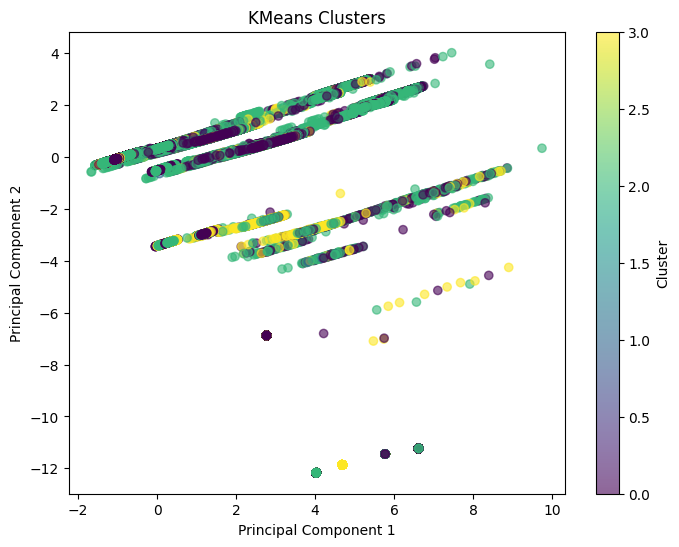

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA to reduce the data to 2 components (for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])

# Add the cluster labels to the DataFrame
pca_df['Cluster'] = filtered_data['Cluster']

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['Cluster'], cmap='viridis', alpha=0.6)
plt.title('KMeans Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
# filter data beyond these data points (time diff >= 9 secs and time diff <= 4 hours)
final_filtered_data = filtered_data[
    (filtered_data['time_diff'] >= pd.Timedelta(seconds=9)) &
    (filtered_data['time_diff'] <= pd.Timedelta(hours=4))
]

#Find the total proportion of data after filtering
prop1 = len(final_filtered_data) / len(filtered_data)
print(f"Proportion of filtered data from relevant months of filtered data: {(prop1)*100:.2f}%")


prop2 = len(final_filtered_data) / len(data)
print(f"Proportion of filtered data from total data: {(prop2)*100:.2f}%")

Proportion of filtered data from relevant months of filtered data: 100.00%
Proportion of filtered data from total data: 56.08%


In [ ]:
# Testing Analog features

analog_data = final_filtered_data[['month', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Motor_current', 'Oil_temperature']]

In [ ]:
# Testing Digital features

digital_data = final_filtered_data[['COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']]

In [ ]:
#Full Data Testing
from sklearn.ensemble import RandomForestClassifier

# Define X  and y (label)
X = data[['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Motor_current', 'Oil_temperature', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']]
y = data['Is Anomaly?']

# Train Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Extract feature importance
importances = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importance)

            Feature  Importance
3       DV_pressure        0.30
6   Oil_temperature        0.28
4        Reservoirs        0.11
1               TP3        0.10
0               TP2        0.07
2                H1        0.06
5     Motor_current        0.05
10              MPG        0.01
7              COMP        0.01
8        DV_eletric        0.01
11              LPS        0.00
9            Towers        0.00
13        Oil_level        0.00
14  Caudal_impulses        0.00
12  Pressure_switch        0.00


## ISOLATION FOREST

In [ ]:
kritika_file_path = '/content/drive/MyDrive/DVA Group Project/Proposal/MetroPT3(AirCompressor).csv'
data = import_data(kritika_file_path)
data.head()

data['timestamp'] = pd.to_datetime(data['timestamp'])

data = data.sort_values(by='timestamp').reset_index(drop=True)

data['time_diff'] = data['timestamp'].diff()  # Difference in seconds

data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File loaded successfully!


,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,time_diff
0,0,2020-02-01 00:00:00,-0.01,9.36,9.34,-0.02,9.36,53.60,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,NaT
1,10,2020-02-01 00:00:10,-0.01,9.35,9.33,-0.02,9.35,53.68,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,0 days 00:00:10
2,20,2020-02-01 00:00:19,-0.01,9.34,9.32,-0.02,9.34,53.60,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,0 days 00:00:09
3,30,2020-02-01 00:00:29,-0.01,9.33,9.31,-0.02,9.33,53.42,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,0 days 00:00:10
4,40,2020-02-01 00:00:39,-0.01,9.32,9.30,-0.02,9.32,53.48,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,0 days 00:00:10


In [ ]:
# Convert 'Start Time' and 'End Time' to datetime
failure_data['Start Time'] = pd.to_datetime(failure_data['Start Time'])
failure_data['End Time'] = pd.to_datetime(failure_data['End Time'])

In [ ]:
from sklearn.ensemble import IsolationForest
# Define function to apply Isolation Forest
def detect_anomalies_in_period(data, period_start, period_end):
    # Filter data for the given period
    period_data = data[(data['timestamp'] >= period_start) & (data['timestamp'] <= period_end)]

    # Select features (you can add more features as needed)
    features = period_data[['TP2', 'DV_pressure', 'Motor_current', 'LPS', 'Oil_level']]

    # Initialize Isolation Forest model
    model = IsolationForest(contamination=0.05, random_state=42)

    # Fit the model
    model.fit(features)

    # Predict anomalies
    anomalies = model.predict(features)

    # Add anomaly column to the data (1 for normal, -1 for anomaly)
    period_data['anomaly'] = anomalies

    return period_data




In [ ]:
#loop through failure events and apply anomaly detection
anomalies_data = []
for i, failure_row in failure_data.iterrows():
    # Get the time period before each failure event
    if i == 0:  # First period: from the start of data to failure 1 start time
        period_start = data['timestamp'].min()
    else:  # Other periods: from failure end to next failure start
        period_start = failure_data.iloc[i-1]['End Time']

    period_end = failure_row['Start Time']

    # Detect anomalies for the current time period
    anomalies_period = detect_anomalies_in_period(data, period_start, period_end)

    # Append the result to the list
    anomalies_data.append(anomalies_period)

# Combine all the anomaly data from different periods
anomalies_combined = pd.concat(anomalies_data)

<ipython-input-30-b5472f744f3a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['anomaly'] = anomalies
<ipython-input-30-b5472f744f3a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['anomaly'] = anomalies
<ipython-input-30-b5472f744f3a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [ ]:
for i, failure_row in failure_data.iterrows():
    # Get the time period before each failure event
    if i == 0:  # First period: from the start of data to failure 1 start time
        period_start = data['timestamp'].min()
    else:  # Other periods: from failure end to next failure start
        period_start = failure_data.iloc[i-1]['End Time']

    period_end = failure_row['Start Time']

    #Detect anomalies for the current time period
    anomalies_period = detect_anomalies_in_period(data, period_start, period_end)

    # Append the result to the list
    anomalies_data.append(anomalies_period)

# Combine all the anomaly data from different periods
anomalies_combined = pd.concat(anomalies_data)

# View anomalies
print(anomalies_combined[['timestamp', 'TP2', 'DV_pressure', 'Motor_current', 'LPS', 'Oil_level', 'anomaly']])

<ipython-input-30-b5472f744f3a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['anomaly'] = anomalies
<ipython-input-30-b5472f744f3a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['anomaly'] = anomalies
<ipython-input-30-b5472f744f3a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

                  timestamp   TP2  DV_pressure  Motor_current  LPS  Oil_level  \
0       2020-02-01 00:00:00 -0.01        -0.02           0.04 0.00       1.00   
1       2020-02-01 00:00:10 -0.01        -0.02           0.04 0.00       1.00   
2       2020-02-01 00:00:19 -0.01        -0.02           0.04 0.00       1.00   
3       2020-02-01 00:00:29 -0.01        -0.02           0.04 0.00       1.00   
4       2020-02-01 00:00:39 -0.01        -0.02           0.04 0.00       1.00   
...                     ...   ...          ...            ...  ...        ...   
1171089 2020-07-15 14:29:21 10.00        -0.01           5.97 0.00       1.00   
1171090 2020-07-15 14:29:31 10.04        -0.01           5.97 0.00       1.00   
1171091 2020-07-15 14:29:41  9.87        -0.01           5.85 0.00       1.00   
1171092 2020-07-15 14:29:51  9.93        -0.01           5.93 0.00       1.00   
1171093 2020-07-15 14:30:00  9.96        -0.01           5.94 0.00       1.00   

         anomaly  
0       

<ipython-input-33-32c5bf6f458a>:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


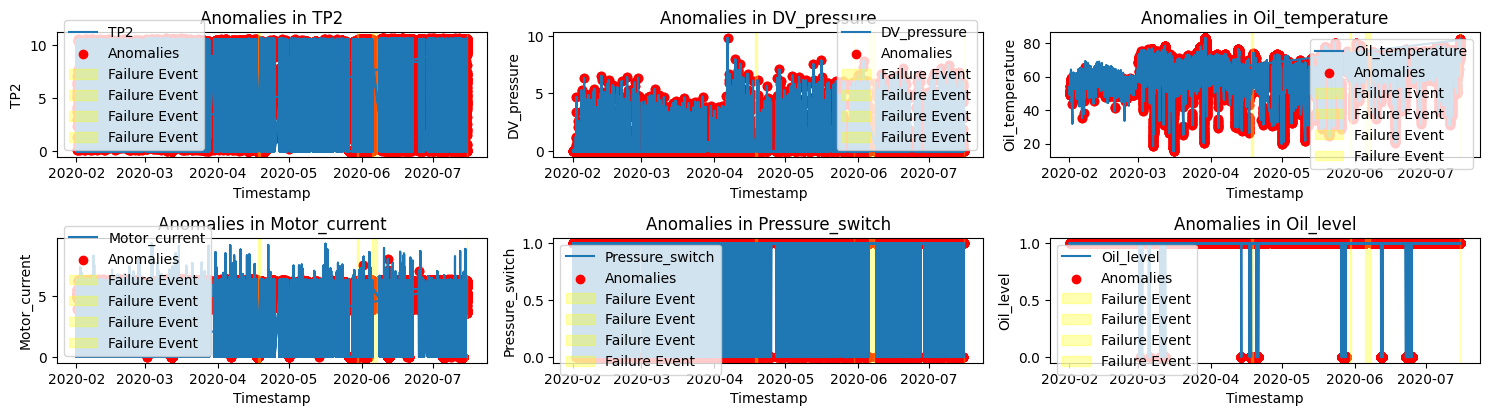

In [ ]:
#plot the anomalies for each feature
features = ['TP2', 'DV_pressure', 'Oil_temperature', 'Motor_current', 'Pressure_switch', 'Oil_level']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(5, 3, i+1)
    plt.plot(anomalies_combined['timestamp'], anomalies_combined[feature], label=feature)
    plt.scatter(anomalies_combined[anomalies_combined['anomaly'] == -1]['timestamp'],
                anomalies_combined[anomalies_combined['anomaly'] == -1][feature],
                color='red', label='Anomalies')

    #highlight failure events
    for _, failure_row in failure_data.iterrows():
        plt.axvspan(failure_row['Start Time'], failure_row['End Time'], color='yellow', alpha=0.3, label='Failure Event')

    plt.xlabel('Timestamp')
    plt.ylabel(feature)
    plt.title(f'Anomalies in {feature}')
    plt.legend()

plt.tight_layout()
plt.show()

## SVM Modeling

In [ ]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['month'] = data['timestamp'].dt.month

failure_periods = [
    ("2020-04-18 00:00", "2020-04-18 23:59"),
    ("2020-05-29 23:30", "2020-05-30 06:30"),
    ("2020-06-05 10:00", "2020-06-07 14:30"),
    ("2020-07-15 14:30", "2020-07-15 19:00")
]

failure_periods = [
    (pd.to_datetime(start), pd.to_datetime(end)) for start, end in failure_periods
]

# Labels:
# - 0 = not a failure (Includes failures)
# - 1 = N hours before failure

N_hours = 5 * 24

# Iterate through the failure periods and assign labels
for start, end in failure_periods:
    two_hours_before_start = start - pd.Timedelta(hours=N_hours)
    time_frame = (data["timestamp"] >= two_hours_before_start) & (
        data["timestamp"] < start
    )
    data.loc[time_frame, "Target"] = 1

data['Target'].fillna(int(0), inplace=True)

# Print the first few rows of the updated DataFrame
data.head()


Mounted at /content/drive
File loaded successfully!


<ipython-input-4-a6c1fef7b4ce>:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Target'].fillna(int(0), inplace=True)


,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,month,Target
0,0,2020-02-01 00:00:00,-0.01,9.36,9.34,-0.02,9.36,53.60,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,2,0.00
1,10,2020-02-01 00:00:10,-0.01,9.35,9.33,-0.02,9.35,53.68,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,2,0.00
2,20,2020-02-01 00:00:19,-0.01,9.34,9.32,-0.02,9.34,53.60,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,2,0.00
3,30,2020-02-01 00:00:29,-0.01,9.33,9.31,-0.02,9.33,53.42,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,2,0.00
4,40,2020-02-01 00:00:39,-0.01,9.32,9.30,-0.02,9.32,53.48,0.04,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,2,0.00


In [ ]:
from imblearn.under_sampling import NearMiss
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd

data['timestamp'] = pd.to_datetime(data['timestamp'])
data['month'] = data['timestamp'].dt.month

data["Target"].value_counts()

X = data[['DV_pressure', 'Oil_temperature', "LPS", "Oil_level", "Caudal_impulses"]] # this is purely a classification no time steps are needed
y = data["Target"]

nm_undersampler = NearMiss(version=3, n_neighbors_ver3=3, n_jobs=-1)
X, y = nm_undersampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

svm = SVC(kernel="rbf", probability=True, random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print(classification_report(y_test, y_pred))

confusion_matrix(y_test, y_pred, normalize="true")


/usr/local/lib/python3.11/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:206: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.64      0.15      0.24      7799
         1.0       0.86      0.98      0.92     40961

    accuracy                           0.85     48760
   macro avg       0.75      0.57      0.58     48760
weighted avg       0.82      0.85      0.81     48760



array([[0.14886524, 0.85113476],
       [0.01628378, 0.98371622]])

## Logistic Regression

Post sampling split:
X 272336
y 272336
Resampled class distribution: Counter({0.0: 136168, 1.0: 136168})
Threshold: 0.00 | Precision: 0.50 | Recall: 1.00 | F1: 0.67
Threshold: 0.05 | Precision: 0.50 | Recall: 1.00 | F1: 0.67
Threshold: 0.10 | Precision: 0.50 | Recall: 0.95 | F1: 0.65
Threshold: 0.15 | Precision: 0.52 | Recall: 0.92 | F1: 0.66
Threshold: 0.20 | Precision: 0.56 | Recall: 0.89 | F1: 0.69
Threshold: 0.25 | Precision: 0.63 | Recall: 0.87 | F1: 0.73
Threshold: 0.30 | Precision: 0.69 | Recall: 0.85 | F1: 0.76
Threshold: 0.35 | Precision: 0.75 | Recall: 0.83 | F1: 0.79
Threshold: 0.40 | Precision: 0.82 | Recall: 0.81 | F1: 0.81
Threshold: 0.45 | Precision: 0.87 | Recall: 0.78 | F1: 0.82
Threshold: 0.50 | Precision: 0.92 | Recall: 0.75 | F1: 0.82
Threshold: 0.55 | Precision: 0.95 | Recall: 0.71 | F1: 0.82
Threshold: 0.60 | Precision: 0.97 | Recall: 0.68 | F1: 0.80
Threshold: 0.65 | Precision: 0.99 | Recall: 0.65 | F1: 0.78
Threshold: 0.70 | Precision: 0.99 | Recall: 0.54 | F1: 

<Figure size 1000x600 with 0 Axes>

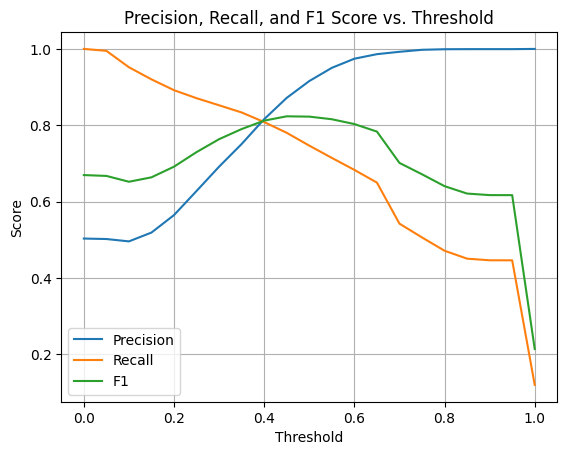

              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85     40591
         1.0       0.92      0.75      0.82     41110

    accuracy                           0.84     81701
   macro avg       0.85      0.84      0.84     81701
weighted avg       0.85      0.84      0.84     81701



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from sklearn.compose import ColumnTransformer
from collections import Counter
import matplotlib.pyplot as plt


# Assuming df_filtered is your DataFrame
X = data[['DV_pressure', 'Oil_temperature', "COMP", "LPS", "DV_eletric", "MPG", "Oil_level", "Caudal_impulses", "TP2", "Motor_current" ]]
y = data["Target"]

# Apply NearMiss to undersample
nm_undersampler = NearMiss(sampling_strategy=1)
X_resampled, y_resampled = nm_undersampler.fit_resample(X, y)

print("Post sampling split:")
print("X", len(X_resampled))
print("y", len(y_resampled))
print("Resampled class distribution:", Counter(y_resampled))

sample_indices = nm_undersampler.sample_indices_
filtered_indices = X.index[sample_indices]
time_stamps = data.loc[filtered_indices].reset_index(drop=True)['timestamp']
X_resampled['time'] = time_stamps

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

time_stamps_nums = X_test['time']
X_train = X_train.drop(columns = ['time'])
X_test = X_test.drop(columns = ['time'])


# Train the Logistic Regression model with n_jobs for parallel processing
log_reg = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
log_reg.fit(X_train, y_train)


# Make predictions
y_pred = log_reg.predict(X_test)

y_prob = log_reg.predict_proba(X_test)[:, 1]  # This gets the probabilities for class 1

thresholds = np.arange(0.0, 1.05, 0.05)
scores = []

for t in thresholds:
    y_pred_thresh = (y_prob >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_thresh, average='binary')
    scores.append((precision, recall, f1))
    print(f"Threshold: {t:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")
scores_df = pd.DataFrame(scores, columns=["Precision", "Recall", "F1"], index=thresholds)

plt.figure(figsize=(10,6))
scores_df.plot()
plt.title("Precision, Recall, and F1 Score vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

opt_threshold = 0.4
y_pred_thresh = (y_prob >= opt_threshold).astype(int)  # Convert probabilities to binary class labels

#print(f"Classification report for threshold {threshold}:")
#print(classification_report(y_test, y_pred_thresh))

# Convert numeric timestamps back to datetime
#X_test['timestamp_converted'] = pd.to_datetime(time_stamps_nums, unit='s')


# Extract the original timestamps from the filtered DataFrame using indices from X_test
predictions_df = pd.DataFrame({
    'timestamp': time_stamps_nums,
    'prediction': y_prob
})
pd.reset_option('display.max_rows')

# Output the prediction report
print(classification_report(y_test, y_pred))

# Display the predictions DataFrame
#print(predictions_df)